#Problem 6

##PCA 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
#read the txt file
data=np.loadtxt("3Ddata.txt")

X=data[:,0:3]
label=data[:,3]

#PCA algorithm
def PCA(X,k):
    nsample=X.shape[0]
    ndim=X.shape[1]
    
    #center the data
    X=X-np.mean(X,0)
    
    #compute the sample covariance matrix
    sigma=np.dot(X.T,X)/nsample
    
    #compute the eigen value and eigen vector
    w,v=np.linalg.eig(sigma)
    ind=np.argsort(w)
    ind=ind[::-1]
    eighv=v[:,ind[:k]]
    
    #compute the scores matrix
    scores=-np.dot(X,eighv)
    
    return scores

Text(0.5,1,'Principal Component Analysis')

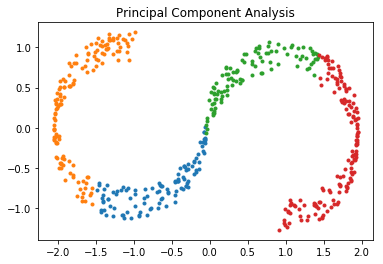

In [2]:
#plot the image
X_pca=PCA(X,2)
for i in range(1,5):
    plt.plot(X_pca[label==i,0],X_pca[label==i,1],'.')
plt.title("Principal Component Analysis")

##Isomap

In [3]:
#Isomap analysis
inf=np.inf
#find k-nearest neighbour of given data
def k_nearest_neighbour(i,X,k):
    temp=X-X[i,:]
    distance=np.sqrt(np.sum(np.multiply(temp,temp),1))
    
    #sort the index and distance with asecending
    index=np.argsort(distance)[1:(k+1)]
    distance_knearest=distance[index]
    
    return index,distance_knearest

#construct graph distance matrix
def graph_distance(X,k):
    nsample=X.shape[0]
    graph_matrix=np.zeros((nsample,nsample))
    for i in range(nsample):
        index,distance=k_nearest_neighbour(i,X,k)
        index_remain=np.delete(np.arange(nsample),index)
        
        #assign k-neareast neighbours with distance
        graph_matrix[i,index]=distance 
        
        #assign un-nearest points with inf
        graph_matrix[i,index_remain]=inf
        
        #assign itself with 0
        graph_matrix[i,i]=0
        
    return graph_matrix

#compute shortest path distance
def shorest_path(graph_matrix):
    #assign A with initial value of graph_matrix
    A=graph_matrix.copy()
    nsample=A.shape[0]
    #Floyd–Warshall algorithm
    for k in range(nsample):
        for i in range(nsample):
            for j in range(nsample):
                if A[i,j]>A[i,k]+A[k,j]:
                    A[i,j]=A[i,k]+A[k,j]
    return A

#compute Multidimensional scaling
def MDS(A,ndim):
    nsample=A.shape[0]
    
    #compute centered gram matrix
    P=np.eye(nsample)-np.ones((nsample,nsample))/nsample
    A=A**2
    gram_matrix=-0.5*np.dot(P,A).dot(P)
    
    #compute eigendecomposition of gram matrix
    w,v=np.linalg.eig(gram_matrix)
    ind=np.argsort(w)
    ind=ind[::-1]
    
    #extract diagnoal matrix and low-dimensional data
    lamb=np.concatenate((np.diag(np.sqrt(w[ind[:ndim]])),\
                         np.zeros((nsample-ndim,ndim))),axis=0)
    y=np.dot(v[:,ind],lamb)
    
    return np.real(y)

#Isomap method
def Isomap(X,k,ndim):
    
    #compute graph distance
    graph_matrix=graph_distance(X,k)
    
    #compute the shorest path distance
    A=shorest_path(graph_matrix)
    
    #compute Multidimensional scaling
    y=MDS(A,ndim)
    
    return y

In [4]:
k=10
ndim=2
y=Isomap(X,k,ndim)

Text(0.5,1,'Isomap')

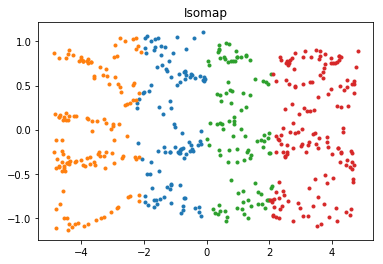

In [5]:
for i in range(1,5):
    plt.plot(y[label==i,0],y[label==i,1],'.')
plt.title("Isomap")

##Locally Linear Embedding

In [6]:
#find the weights
def weight_matrix(X,k,alpha):
    nsample=X.shape[0]
    weight=np.zeros((nsample,nsample))
    for i in range(nsample):
        #find k-nearest neighbours
        index,distance=k_nearest_neighbour(i,X,k)
        Z=X[index,:]-X[i,:]
        
        #compute gram matrix of neighbours
        gram_matrix=np.dot(Z,Z.T)
        
        #compute the weights of neighbours
        weight[i,index]=np.dot(np.linalg.inv(gram_matrix+np.eye(k)*alpha),np.ones((k,1))).T
        
        #normalize it to sum 1
        weight[i,index]=weight[i,index]/np.sum(weight[i,index])
    
    return weight

#find the coordinates
def new_coordinate(X,weight,ndim):
    nsample=X.shape[0]
    
    #compute matrix (I-W)'*(I-W)
    M=np.dot((np.eye(nsample)-weight).T,(np.eye(nsample)-weight))
    
    #compute eigen value and vector
    w,v=np.linalg.eig(M)
    ind=np.argsort(w)
    
    #extract bottom k+1 eigenvectors excluding 1 vector 
    coords=v[:,ind[1:(ndim+1)]]*np.sqrt(nsample)
    
    return np.real(coords)

def LLE(X,k,ndim,alpha):
    
    #find the weights
    weight=weight_matrix(X,k,alpha)
    
    #find the coordinates
    coords=new_coordinate(X,weight,ndim)
    
    return coords

In [7]:
k=10
ndim=2
alpha=0.003
coords=LLE(X,k,ndim,alpha)

Text(0.5,1,'LLE')

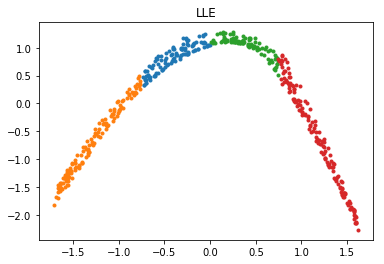

In [8]:
for i in range(1,5):
    plt.plot(coords[label==i,0],coords[label==i,1],'.')
plt.title("LLE")

As we can see, these three methods have different reduction results. For PCA, its goal is to find a projection plane such that mean squared error of projection is minimized. The original 3-dimensional data is like a S shape. Therefore, the PCA reduction is a S shape. As for ISomap, it keeps the relationship between neighbors and flat the data in oringal space. So we can see a rectangle which is clearly splited into four parts. LLE method assumes each point should be approximately reconstructable as a linear combination of its neighbors and also keeps the relationships between neighbors. Since it's constructed by linear combination of its neighbors, it will be close to linear shape just as we see in the above figure.

#Problem 7

In [9]:
#loading data
train=np.loadtxt('train35.digits')
train=np.concatenate((train,np.ones((2000,1))),axis=1)
train_label=np.loadtxt("train35.labels")
test=np.loadtxt("test35-1.digits")
test=np.concatenate((test,np.ones((200,1))),axis=1)

#normalize the data to unit norm
train=preprocessing.normalize(train, norm='l2')
test=preprocessing.normalize(test, norm='l2')

In [10]:
def batchperceptron(train,train_label,M):
    
    n=train.shape[0] #sample size
    ndim=train.shape[1] #sample dimension
    #initalize the weight
    w=np.zeros(ndim)
    error=np.zeros(M)
    k=0
    flag=1
    while(k<M and flag):
        flag=0
        for i in range(n):
            u=np.sum(np.multiply(w,train[i,:]))
            if train_label[i]*u<=0:
                w=w+train_label[i]*train[i,:]
                flag=1
        error[k]=np.sum(np.multiply(train_label,np.sum(np.multiply(train,w),1))<=0)
        k=k+1
    return w,error

#using K-folding cross validation to choose optimal M
def M_crossvalidation(train,train_label,K):
    nsample=train.shape[0]
    subsize=nsample/K
    m=np.arange(1,15)
    error=np.zeros(len(m))
    for M in m:
        for i in range(K):
            test_ind=np.arange(i*subsize,(i+1)*subsize,dtype="int")
            train_ind=np.delete(np.arange(nsample),test_ind)
            w,er=batchperceptron(train[train_ind,:],train_label[train_ind],M)
            error[M-1]+=np.sum(np.multiply(train_label[test_ind],\
                            np.sum(np.multiply(train[test_ind],w),1))<=0)
    
    M_best=np.argmin(error)+1
    
    return M_best

In [11]:
#choose best M
M_best=M_crossvalidation(train,train_label,5)
print(M_best)

8


In [12]:
#train w using train data
w,error=batchperceptron(train,train_label,M_best)

#prediciton test label
test_label=np.sum(np.multiply(test,w),1)
test_label[test_label>0]=1
test_label[test_label<=0]=-1

#save test label
np.savetxt("test35.predictions", test_label, fmt="%d", delimiter=",")

Text(0,0.5,'Mistakes')

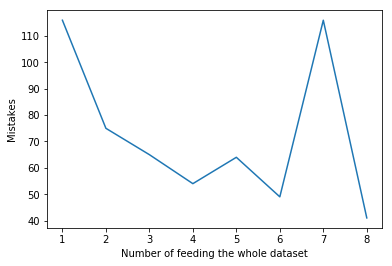

In [13]:
plt.plot(np.arange(1,M_best+1),error)
plt.xlabel('Number of feeding the whole dataset')
plt.ylabel('Mistakes')

According to above figure, we see that the number of mistakes decreases with increasing examples at first, but it increases after 5 times feeding and 7 times feeding. In other words, it will not always decrease with increasing examples, there exists some certain number that achieve the smallest mistake number.